In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.graph_objects as go

In [3]:
manifest_path = "../out/2025-12-14_16-39-46/manifest.csv"
df = pd.read_csv(manifest_path)
df

,accession,local_file_path,genome_size,contig_count,mean_contig_length,longest_contig,n50_contigs,plasmid_count,checkm2_completeness,checkm2_contamination,gtdb_taxonomy,domain,phylum,class,order,family,genus,species
0,RS_GCF_010645065.1,/nfs_share/yasutake/projects/metagenome/gtdb/2...,5114933,117,43717,896865,183479,0.0,99.98,2.26,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Flavobacteriaceae,g__Flavobacterium,s__Flavobacterium fluviatile
1,RS_GCF_004570605.1,/nfs_share/yasutake/projects/metagenome/gtdb/2...,2027228,219,9256,103322,26582,0.0,99.62,0.15,d__Bacteria;p__Bacillota;c__Bacilli;o__Lactoba...,d__Bacteria,p__Bacillota,c__Bacilli,o__Lactobacillales,f__Aerococcaceae,g__WM01,s__WM01 sp004570605
2,RS_GCF_031457235.1,/nfs_share/yasutake/projects/metagenome/gtdb/2...,5538500,51,108598,908384,268368,0.0,100.00,1.36,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,d__Bacteria,p__Pseudomonadota,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Hydrogenophaga,s__Hydrogenophaga laconesensis
3,RS_GCF_040957575.1,/nfs_share/yasutake/projects/metagenome/gtdb/2...,3882843,2,1941421,3007948,3007948,1.0,100.00,0.34,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,d__Bacteria,p__Pseudomonadota,c__Gammaproteobacteria,o__Enterobacterales,f__Vibrionaceae,g__Vibrio,s__Vibrio sp030730965
4,RS_GCF_964019755.1,/nfs_share/yasutake/projects/metagenome/gtdb/2...,1120781,1,1120781,1120781,1120781,0.0,97.43,0.33,d__Bacteria;p__Bacillota;c__Bacilli;o__Mycopla...,d__Bacteria,p__Bacillota,c__Bacilli,o__Mycoplasmatales,f__Mycoplasmataceae,g__Spiroplasma,s__Spiroplasma sp964019755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33560,RS_GCF_025998175.1,/nfs_share/yasutake/projects/metagenome/gtdb/2...,1775052,1,1775052,1775052,1775052,0.0,99.95,0.10,d__Archaea;p__Thermoproteota;c__Nitrososphaeri...,d__Archaea,p__Thermoproteota,c__Nitrososphaeria,o__Nitrososphaerales,f__Nitrosopumilaceae,g__Nitrosopumilus,s__Nitrosopumilus zosterae
33561,RS_GCF_000148385.1,/nfs_share/yasutake/projects/metagenome/gtdb/2...,2374137,1,2374137,2374137,2374137,0.0,99.99,0.34,d__Archaea;p__Thermoproteota;c__Thermoprotei;o...,d__Archaea,p__Thermoproteota,c__Thermoprotei,o__Thermoproteales,f__Thermocladiaceae,g__Vulcanisaeta,s__Vulcanisaeta distributa
33562,RS_GCF_014876775.1,/nfs_share/yasutake/projects/metagenome/gtdb/2...,1625846,1,1625846,1625846,1625846,0.0,99.95,0.91,d__Archaea;p__Thermoproteota;c__Thermoprotei;o...,d__Archaea,p__Thermoproteota,c__Thermoprotei,o__Thermofilales,f__Thermofilaceae,g__Infirmifilum,s__Infirmifilum lucidum
33563,GB_GCA_000230955.3,/nfs_share/yasutake/projects/metagenome/gtdb/2...,3162560,2,1581280,2846968,2846968,1.0,99.81,0.09,d__Archaea;p__Halobacteriota;c__Halobacteria;o...,d__Archaea,p__Halobacteriota,c__Halobacteria,o__Halobacteriales,f__Halobacteriaceae,g__Halobacterium,s__Halobacterium sp000230955


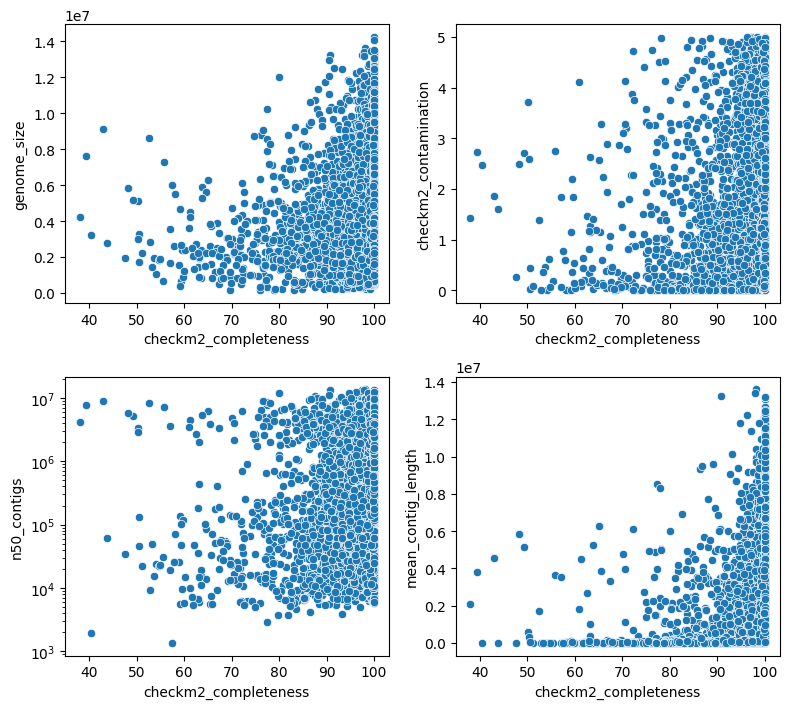

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7.2))
target_cols = ['genome_size', 'checkm2_contamination', 'n50_contigs', 'mean_contig_length']

for ax, col in zip(axes.flat, target_cols):
    sns.scatterplot(
        data=df, x='checkm2_completeness', y=col, 
        ax=ax
    )
    if 'n50' in col:
        ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [17]:
# 1. Isolateデータのみ抽出 & 必要な階層の定義
levels = ['domain', 'phylum', 'class', 'order']
top_n = 10 # 各階層で表示する上位カテゴリー数

# 2. 階層名のクリーニング (p__, c__ などを削除)
for col in levels:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(r'^[a-z]__', '', regex=True)
    else:
        df[col] = "Unknown"

# 3. サンキーダイアグラム用のデータ構造（Source -> Target）を作成する関数
def prepare_sankey_data(df, levels, top_n=10):
    labels = []
    sources = []
    targets = []
    values = []
    
    # ノード（ラベル）のリストを作成
    # 同じ名前（例: "Unknown"）が別の階層にあっても区別できるよう、(階層名, 値) で管理
    unique_nodes = []
    for i, level in enumerate(levels):
        # その階層のTop Nを抽出
        top_counts = df[level].value_counts()
        top_items = top_counts.nlargest(top_n).index.tolist()
        
        # DataFrame上の値を "Others" に置換した一時列を作る
        col_name = f"{level}_masked"
        df[col_name] = df[level].apply(lambda x: x if x in top_items else 'Others')
        
        # ノード登録
        unique_nodes.extend([(i, name) for name in df[col_name].unique()])

    # ノード名からインデックスへの辞書
    node_map = {node: i for i, node in enumerate(unique_nodes)}
    labels = [name for _, name in unique_nodes]
    
    # リンク（Source -> Target）の計算
    for i in range(len(levels) - 1):
        src_col = f"{levels[i]}_masked"
        tgt_col = f"{levels[i+1]}_masked"
        
        # Groupbyでペアの件数を数える
        flow_counts = df.groupby([src_col, tgt_col]).size().reset_index(name='count')
        
        for _, row in flow_counts.iterrows():
            src_node = (i, row[src_col])
            tgt_node = (i+1, row[tgt_col])
            
            sources.append(node_map[src_node])
            targets.append(node_map[tgt_node])
            values.append(row['count'])
            
    return labels, sources, targets, values

# データ生成
labels, sources, targets, values = prepare_sankey_data(df, levels, top_n=10)

# 4. 描画
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = labels,
        color = "rgba(100, 149, 237, 0.6)" # ノードの色（落ち着いた青）
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values,
        color = "rgba(200, 200, 200, 0.4)" # リンクの色（薄いグレーで半透明に）
    )
)])

fig.update_layout(
    title_text="Taxonomic Flow of Genomes (Phylum → Class → Order)",
    font_size=12,
    height=600,
    width=1000
)

fig.show()

In [21]:
# サンプルデータがない場合のダミー生成用（お手元のdfがある場合は無視してください）
# df = pd.read_csv(...) 

# ==========================================
# 1. 設定
# ==========================================
levels = ['domain', 'phylum', 'class'] # 見たい階層の順番
top_n_local = 3  # ★ここを変更: 「親カテゴリごとの」上位数

# 階層名のクリーニング (p__, c__ などを削除)
for col in levels:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(r'^[a-z]__', '', regex=True)
    else:
        df[col] = "Unknown"

# ==========================================
# 2. 親階層ごとのTop N抽出ロジック (ここが核心)
# ==========================================
def filter_hierarchy_locally(df, levels, top_n=3):
    """
    上位の階層から順に、親カテゴリ内で出現頻度が高いTop Nのみを残し、
    それ以外を 'Others' に置換する。
    """
    df_plot = df.copy()
    
    # 最初の階層（例: domain）は親がいないので、グローバルにTop Nをとるか、そのまま
    # ここではシンプルに「最初の階層は全部表示（あるいは別途フィルタ）」とし、
    # 2階層目（Phylum）以降に対して「親の中でのTop N」を適用します。
    
    for i in range(len(levels) - 1):
        parent_col = levels[i]
        child_col = levels[i+1]
        
        # 親と子のペアごとの出現数をカウント
        counts = df_plot.groupby([parent_col, child_col]).size().reset_index(name='count')
        
        # 親ごとにランク付け (countが多い順)
        counts['rank'] = counts.groupby(parent_col)['count'].rank(method='first', ascending=False)
        
        # Top Nに入る「(親, 子)」の組み合わせセットを作成
        valid_pairs = set(
            zip(counts[counts['rank'] <= top_n][parent_col], 
                counts[counts['rank'] <= top_n][child_col])
        )
        
        # DataFrameの値を更新 (リスト内包表記で高速化)
        # 「(親, 子)のペアがTop Nセットになければ 'Others' にする」
        new_values = [
            c if (p, c) in valid_pairs else 'Others'
            for p, c in zip(df_plot[parent_col], df_plot[child_col])
        ]
        
        df_plot[child_col] = new_values

    return df_plot

# フィルタリング適用
df_masked = filter_hierarchy_locally(df, levels, top_n=top_n_local)

# ==========================================
# 3. サンキーダイアグラム用データ作成
# ==========================================
def prepare_sankey_data_simple(df, levels):
    labels = []
    sources = []
    targets = []
    values = []
    
    # ノードリストの作成
    # (階層インデックス, 名前) でユニークなIDを作る
    unique_nodes = []
    for i, level in enumerate(levels):
        unique_vals = df[level].unique()
        for val in unique_vals:
            unique_nodes.append((i, val))
            
    # ノード名からインデックス(0, 1, 2...)への辞書
    node_map = {node: idx for idx, node in enumerate(unique_nodes)}
    labels = [name for _, name in unique_nodes]
    
    # リンク（Source -> Target）の計算
    for i in range(len(levels) - 1):
        src_col = levels[i]
        tgt_col = levels[i+1]
        
        # 集計
        flow_counts = df.groupby([src_col, tgt_col]).size().reset_index(name='count')
        
        for _, row in flow_counts.iterrows():
            # SourceとTargetのIDを取得
            src_node = (i, row[src_col])
            tgt_node = (i+1, row[tgt_col])
            
            sources.append(node_map[src_node])
            targets.append(node_map[tgt_node])
            values.append(row['count'])
            
    return labels, sources, targets, values

labels, sources, targets, values = prepare_sankey_data_simple(df_masked, levels)

# ==========================================
# 4. 描画
# ==========================================
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = labels,
        color = "rgba(100, 149, 237, 0.6)"
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values,
        color = "rgba(200, 200, 200, 0.4)"
    )
)])

fig.update_layout(
    title_text=f"Taxonomic Flow (Top {top_n_local} per parent)",
    font_size=12,
    height=600,
    width=1000
)

fig.show()